# **ANOVA Analysis, Linear Regression and Random Forest Regression**

In [ ]:
!pip install researchpy
!pip install pingouin

In [54]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import researchpy as rp
import statsmodels.stats.multicomp
import statsmodels.api as sm
import scipy
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import linear_model, ensemble 
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [12]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
    
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

**2^k Factorial Design**

In [13]:
# Data of 48 experiments (2^k factorial with 4 factors (low -1, high 1 levels) and 3 replications)
df2k = pd.read_csv("experimentResults2k.csv", sep=";")

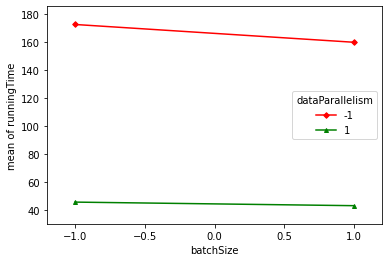

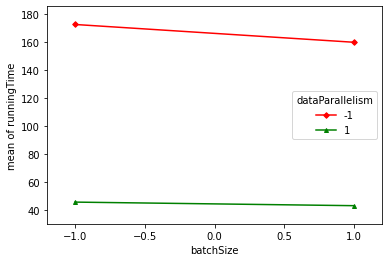

In [14]:
# Interaction plot of batch size and data parallelism factors 
# Determining if the interaction factor is relevant based on the plot's lines
interaction_plot(df2k.batchSize,df2k.dataParallelism, df2k.runningTime,
             colors=['red','green'], markers=['D','^'], ms=4)

In [15]:
# Statistical analysis of the experiments' data
rp.summary_cont(df2k.groupby(['dataParallelism', 'executorCore','learningRate', 'batchSize']))['runningTime']

N  ...  Interval
dataParallelism executorCore learningRate batchSize     ...          
-1              -1           -1           -1         3  ...  228.1183
                                           1         3  ...  191.7991
                              1           -1         3  ...  192.1662
                                           1         3  ...  191.1062
                 1           -1           -1         3  ...  169.5737
                                           1         3  ...  149.8998
                              1           -1         3  ...  158.5249
                                           1         3  ...  144.0829
 1              -1           -1           -1         3  ...   52.8069
                                           1         3  ...   50.3459
                              1           -1         3  ...   51.8826
                                           1         3  ...   50.4044
                 1           -1           -1         3  ...   40.8215
                                           1         3  ...   39.0492
                              1           -1         3  ...   42.3596
                                           1         3  ...   38.5079

[16 rows x 6 columns]

In [16]:
# Fitting the data 
model_2k_fact = ols('runningTime ~ C(dataParallelism)*C(executorCore)*C(learningRate)*C(batchSize)', df2k).fit()
model_2k_fact.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            runningTime   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     735.3
Date:                Sun, 24 Oct 2021   Prob (F-statistic):           3.24e-36
Time:                        22:15:19   Log-Likelihood:                -126.82
No. Observations:                  48   AIC:                             285.6
Df Residuals:                      32   BIC:                             315.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================================
                                                                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                             197.7277      2.402     82.303      0.000     192.834     202.621
C(dataParallelism)[T.1]                                                              -147.2077      3.398    -43.327      0.000    -154.128    -140.287
C(executorCore)[T.1]                                                                  -45.8818      3.398    -13.504      0.000     -52.802     -38.961
C(learningRate)[T.1]                                                                   -7.3317      3.398     -2.158      0.039     -14.252      -0.411
C(batchSize)[T.1]                                                                     -16.8587      3.398     -4.962      0.000     -23.779      -9.938
C(dataParallelism)[T.1]:C(executorCore)[T.1]                                           35.1637      4.805      7.318      0.000      25.377      44.951
C(dataParallelism)[T.1]:C(learningRate)[T.1]                                            8.0442      4.805      1.674      0.104      -1.743      17.831
C(executorCore)[T.1]:C(learningRate)[T.1]                                               5.4290      4.805      1.130      0.267      -4.358      15.216
C(dataParallelism)[T.1]:C(batchSize)[T.1]                                              14.1720      4.805      2.950      0.006       4.385      23.959
C(executorCore)[T.1]:C(batchSize)[T.1]                                                  5.2139      4.805      1.085      0.286      -4.573      15.001
C(learningRate)[T.1]:C(batchSize)[T.1]                                                  6.8785      4.805      1.432      0.162      -2.909      16.666
C(dataParallelism)[T.1]:C(executorCore)[T.1]:C(learningRate)[T.1]                      -5.6134      6.795     -0.826      0.415     -19.455       8.228
C(dataParallelism)[T.1]:C(executorCore)[T.1]:C(batchSize)[T.1]                         -3.8904      6.795     -0.573      0.571     -17.732       9.951
C(dataParallelism)[T.1]:C(learningRate)[T.1]:C(batchSize)[T.1]                         -7.2524      6.795     -1.067      0.294     -21.094       6.589
C(executorCore)[T.1]:C(learningRate)[T.1]:C(batchSize)[T.1]                            -7.6522      6.795     -1.126      0.268     -21.493       6.189
C(dataParallelism)[T.1]:C(executorCore)[T.1]:C(learningRate)[T.1]:C(batchSize)[T.1]     6.2773      9.610      0.653      0.518     -13.297      25.852
==============================================================================
Omnibus:                       22.926   Durbin-Watson:                   3.096
Prob(Omnibus):                  0.000

In [17]:
# Anova analysis of the 2^k factorial design
anova_table_2k_fact_2way = sm.stats.anova_lm(model_2k_fact, typ= 2)

In [19]:
# Determining the confidence interval
mean_confidence_interval(df2k['runningTime'])

(105.15438595910867, 86.61800894261796, 123.69076297559937)

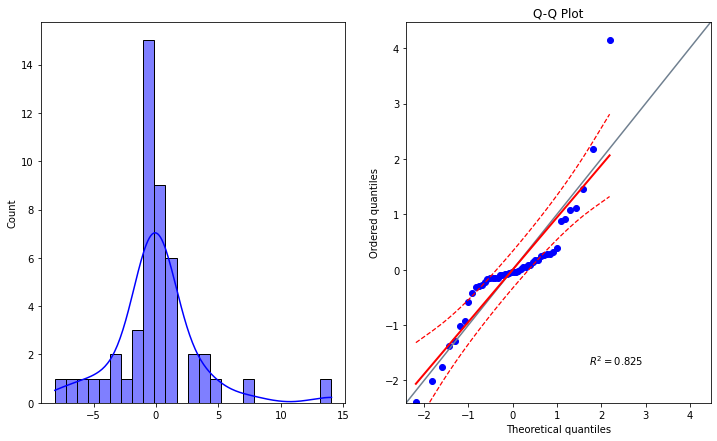

In [20]:
# Plots for standard distribution from the model's residuals
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
sns.histplot(model_2k_fact.resid,kde=True, color ='blue',ax=ax[0])
pg.qqplot(model_2k_fact.resid, dist='norm', ax=ax[1])

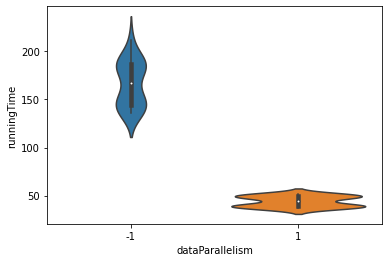

In [21]:
# Plot for the importance of data parallelism across running time
sns.violinplot(x="dataParallelism", y="runningTime", data=df2k)

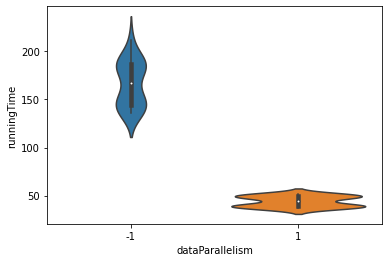

In [22]:
# Plot for the influence of the running time by data parallelism and batch size
sns.violinplot(x="dataParallelism", y="runningTime", data=df2k)

**Full Factorial Design**

In [23]:
# Data for 324 experiments (full factorial, 4 factors (4, 3, 3, 3 levels), 3 repetitions)
df = pd.read_csv('experimentResults.csv', sep=";")

In [24]:
# Statistical analysis of the experiments' data
rp.summary_cont(df.groupby(['dataParallelism', 'executorCore','learningRate', 'batchSize']))['runningTime']

N  ...  Interval
dataParallelism executorCore learningRate batchSize     ...          
1               1000m        0.01         128        3  ...  192.1662
                                          256        3  ...  284.2331
                                          512        3  ...  191.1062
                             0.02         128        3  ...  219.1566
                                          256        3  ...  307.7707
...                                                 ..  ...       ...
4               1250m        0.02         256        3  ...   39.2010
                                          512        3  ...   41.6022
                             0.04         128        3  ...   40.8215
                                          256        3  ...   40.7590
                                          512        3  ...   39.0492

[108 rows x 6 columns]

In [25]:
# Fitting data in the model
model_full_fact = ols('runningTime ~ C(dataParallelism)*C(executorCore)*C(learningRate)*C(batchSize)', df).fit()
model_full_fact.summary2(float_format="%.5f")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                          Results: Ordinary least squares
===================================================================================================================================================
Model:                                         OLS                                         Adj. R-squared:                                0.984    
Dependent Variable:                            runningTime                                 AIC:                                           2190.8325
Date:                                          2021-10-24 22:15                            BIC:                                           2599.1528
No. Observations:                              324                                         Log-Likelihood:                                -987.42  
Df Model:                                      107                                         F-statistic:                                   190.3    
Df Residuals:                                  216                                         Prob (F-statistic):                            8.12e-172
R-squared:                                     0.990                                       Scale:                                         38.968   
---------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                               Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
---------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                     190.3960   3.6041  52.8278 0.0000  183.2923  197.4997
C(dataParallelism)[T.2]                                                                       -91.6511   5.0970 -17.9816 0.0000 -101.6973  -81.6050
C(dataParallelism)[T.3]                                                                      -122.9012   5.0970 -24.1127 0.0000 -132.9473 -112.8551
C(dataParallelism)[T.4]                                                                      -139.1635   5.0970 -27.3033 0.0000 -149.2097 -129.1174
C(executorCore)[T.1125m]                                                                       -0.1873   5.0970  -0.0368 0.9707  -10.2334    9.8588
C(executorCore)[T.1250m]                                                                      -40.4528   5.0970  -7.9367 0.0000  -50.4989  -30.4067
C(learningRate)[T.0.02]                                                                         1.9658   5.0970   0.3857 0.7001   -8.0804   12.0119
C(learningRate)[T.0.04]                                                                         7.3317   5.0970   1.4384 0.1518   -2.7145   17.3778
C(batchSize)[T.256]                                                                            10.6805   5.0970   2.0955 0.0373    0.6344   20.7266
C(batchSize)[T.512]                                                                            -9.9802   5.0970  -1.9581 0.0515  -20.0263    0.0659
C(dataParallelism)[T.2]:C(executorCore)[T.1125m]                                               -9.8445   7.2082  -1.3657 0.1734  -24.0518    4.3629
C(dataParallelism)[T.3]:C(executorCore)[T.1125m]                                               -7.4200   7.2082  -1.0294 0.3045  -21.6273    6.7874
C(dataParallelism)[T.4]:C(executorCore)[T.1125m]                                               -5.9476   7.2082  -0.8251 0.4102  -20.1549    8.2598
C(dataParallelism)[T.2]:C(executorCore)[T.1250m]                                               20.5367   7.2082   2.8491 0.0048    6.3293   34.7441
C(dataParallelism)[T.3]:C(executorCore)[T.1250m]                                               27.0238   7.2082   3.7491 0.0002   12.8165   41.2312
C(dataParalle

In [26]:
# Anova analysis of the full factorial design
anova_table_full_fact_2way = sm.stats.anova_lm(model_full_fact, typ= 2)

# Printing the factors that are statistically relevant
for i in range(1, len(anova_table_full_fact_2way)):
  if anova_table_full_fact_2way["PR(>F)"][i] < 0.05:
    print(anova_table_full_fact_2way.iloc[i])

sum_sq    2.702544e+04
df        2.000000e+00
F         3.467613e+02
PR(>F)    3.708102e-68
Name: C(executorCore), dtype: float64
sum_sq    2.330395e+03
df        2.000000e+00
F         2.990111e+01
PR(>F)    3.439107e-12
Name: C(batchSize), dtype: float64
sum_sq    1.187011e+04
df        6.000000e+00
F         5.076814e+01
PR(>F)    1.136732e-38
Name: C(dataParallelism):C(executorCore), dtype: float64
sum_sq    1296.053736
df           6.000000
F            5.543188
PR(>F)       0.000023
Name: C(dataParallelism):C(batchSize), dtype: float64
sum_sq    416.266389
df          4.000000
F           2.670541
PR(>F)      0.033152
Name: C(executorCore):C(batchSize), dtype: float64
sum_sq    1504.925656
df          12.000000
F            3.218264
PR(>F)       0.000286
Name: C(dataParallelism):C(executorCore):C(batchSize), dtype: float64


In [27]:
print(f"Overall model F({model_full_fact.df_model: .0f},{model_full_fact.df_resid: .0f}) = {model_full_fact.fvalue: .3f}, p = {model_full_fact.f_pvalue: .4f}")

Overall model F( 107, 216) =  190.350, p =  0.0000


In [28]:
# Coefficients of the factors
model_full_fact.params

Intercept                                                                                       190.396033
C(dataParallelism)[T.2]                                                                         -91.651129
C(dataParallelism)[T.3]                                                                        -122.901221
C(dataParallelism)[T.4]                                                                        -139.163536
C(executorCore)[T.1125m]                                                                         -0.187318
                                                                                                   ...    
C(dataParallelism)[T.3]:C(executorCore)[T.1125m]:C(learningRate)[T.0.04]:C(batchSize)[T.512]    -26.052982
C(dataParallelism)[T.4]:C(executorCore)[T.1125m]:C(learningRate)[T.0.04]:C(batchSize)[T.512]    -27.264758
C(dataParallelism)[T.2]:C(executorCore)[T.1250m]:C(learningRate)[T.0.04]:C(batchSize)[T.512]     -8.705960
C(dataParallelism)[T.3]:C(executorCor

In [29]:
# T values for each factor
model_full_fact.tvalues

Intercept                                                                                       52.827791
C(dataParallelism)[T.2]                                                                        -17.981560
C(dataParallelism)[T.3]                                                                        -24.112695
C(dataParallelism)[T.4]                                                                        -27.303292
C(executorCore)[T.1125m]                                                                        -0.036751
                                                                                                  ...    
C(dataParallelism)[T.3]:C(executorCore)[T.1125m]:C(learningRate)[T.0.04]:C(batchSize)[T.512]    -1.807182
C(dataParallelism)[T.4]:C(executorCore)[T.1125m]:C(learningRate)[T.0.04]:C(batchSize)[T.512]    -1.891238
C(dataParallelism)[T.2]:C(executorCore)[T.1250m]:C(learningRate)[T.0.04]:C(batchSize)[T.512]    -0.603895
C(dataParallelism)[T.3]:C(executorCore)[T.1250

In [30]:
# P values for each factor
model_full_fact.pvalues

Intercept                                                                                       1.723223e-125
C(dataParallelism)[T.2]                                                                          8.397236e-45
C(dataParallelism)[T.3]                                                                          3.473333e-63
C(dataParallelism)[T.4]                                                                          5.660385e-72
C(executorCore)[T.1125m]                                                                         9.707176e-01
                                                                                                    ...      
C(dataParallelism)[T.3]:C(executorCore)[T.1125m]:C(learningRate)[T.0.04]:C(batchSize)[T.512]     7.212525e-02
C(dataParallelism)[T.4]:C(executorCore)[T.1125m]:C(learningRate)[T.0.04]:C(batchSize)[T.512]     5.993077e-02
C(dataParallelism)[T.2]:C(executorCore)[T.1250m]:C(learningRate)[T.0.04]:C(batchSize)[T.512]     5.465474e-01
C(dataPara

In [31]:
print(mean_confidence_interval(df['runningTime']))

(88.11535791335282, 82.66883167428719, 93.56188415241846)


In [32]:
# eta_squared - amount of variance accounted for in the sample
# omega_squared - amount of variance accounted for in the population
eta_squared(anova_table_full_fact_2way)
omega_squared(anova_table_full_fact_2way)
print(anova_table_full_fact_2way.round(4))

                                                         sum_sq  ...  omega_sq
C(dataParallelism)                                  745650.7547  ...    0.9294
C(executorCore)                                      27025.4365  ...    0.0336
C(learningRate)                                        176.7821  ...    0.0001
C(batchSize)                                          2330.3949  ...    0.0028
C(dataParallelism):C(executorCore)                   11870.1084  ...    0.0145
C(dataParallelism):C(learningRate)                     180.0658  ...   -0.0001
C(executorCore):C(learningRate)                        189.2438  ...    0.0000
C(dataParallelism):C(batchSize)                       1296.0537  ...    0.0013
C(executorCore):C(batchSize)                           416.2664  ...    0.0003
C(learningRate):C(batchSize)                           235.7345  ...    0.0001
C(dataParallelism):C(executorCore):C(learningRate)     562.0827  ...    0.0001
C(dataParallelism):C(executorCore):C(batchSize)     

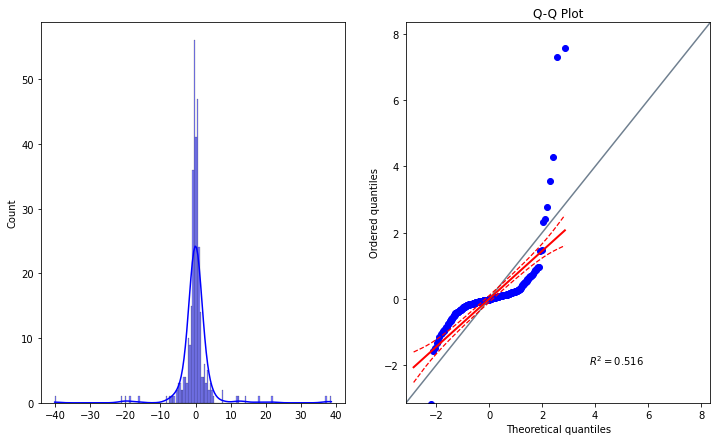

In [33]:
# Plots for standard distribution from the model's residuals
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
sns.histplot(model_full_fact.resid,kde=True, color ='blue',ax=ax[0])
pg.qqplot(model_full_fact.resid, dist='norm', ax=ax[1])

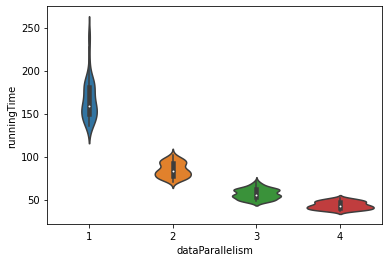

In [34]:
# Plot for the importance of data parallelism across running time
sns.violinplot(x="dataParallelism", y="runningTime", data=df)

(82.0, 90.0)

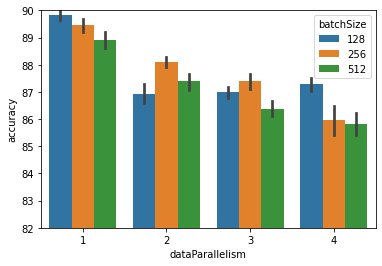

In [35]:
# Plot for the influence of the running time by data parallelism and batch size
g = sns.barplot(x="dataParallelism", y="accuracy",hue="batchSize", data=df)
g.set_ylim(82, 90)

*Defining the datasets using the full factorial design values*

In [80]:
train_df = df[['dataParallelism','executorCore','learningRate','batchSize']]
labels_time = df['runningTime']
labels_acc = df['accuracy']

## Convert Categorical column to numeric
train_df['executorCore'] = pd.Categorical(train_df['executorCore'])
train_df['executorCore'] = train_df.executorCore.cat.codes

x_train, x_test, y_train_acc, y_test_acc = train_test_split(train_df, labels_acc, test_size=0.33, random_state = 42)
x_train, x_test, y_train_time, y_test_time = train_test_split(train_df, labels_time, test_size=0.33, random_state = 42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [81]:
# Defining the training data as a labeled data frame 
train_data = pd.DataFrame(data=x_train, columns=['dataParallelism', 'executorCore', 'learningRate', 'batchSize'])
train_data['runningTime'] = df['runningTime']
train_data['accuracy'] = df['accuracy']

# Fitting the training data into the anova model - running time
model_anova_time = ols('runningTime ~ dataParallelism*executorCore*learningRate*batchSize', train_data).fit()

In [82]:
test_data = pd.DataFrame(data=x_test, columns=['dataParallelism', 'executorCore', 'learningRate', 'batchSize'])

# Prediction on the test data
y_pred_time_anova = model_anova_time.predict(test_data)

In [83]:
# Computing the metrics score
mse = mean_squared_error(y_pred_time_anova, y_test_time)
r2 = r2_score(y_pred_time_anova, y_test_time)

print(f'Time: MSE = {mse}, R2: {r2}')

Time: MSE = 438.456011153327, R2: 0.7995643595217248


In [44]:
# Fitting the training data into the anova model - accuracy
model_anova_accuracy = ols('accuracy ~ dataParallelism*executorCore*learningRate*batchSize', train_data).fit()

y_pred_acc_anova = model_anova_accuracy.predict(test_data)

In [45]:
# Metrics
mse = mean_squared_error(y_pred_acc_anova, y_test_acc)
r2 = r2_score(y_pred_acc_anova, y_test_acc)

print(f'Time: MSE = {mse}, R2: {r2}')

Time: MSE = 0.7577646078746881, R2: 0.5187731789187406


**Linear Regression**

In [78]:
# LR for predicting time
lr_time = linear_model.LinearRegression().fit(x_train, y_train_time)

y_lr_time = lr_time.predict(x_test)

mse = mean_squared_error(y_test_time, y_lr_time)
r2 = r2_score(y_test_time, y_lr_time)
print(f'Time: MSE = {mse}, R2: {r2}')

Time: MSE = 461.83969532698285, R2: 0.8212482399681837


In [79]:
# LR for predicting accuracy
lr_time = linear_model.LinearRegression().fit(x_train, y_train_acc)

y_lr_time = lr_time.predict(x_test)

mse = mean_squared_error(y_test_acc, y_lr_time)
r2 = r2_score(y_test_acc, y_lr_time)
print(f'Time: MSE = {mse}, R2: {r2}')

Time: MSE = 0.7439843790916915, R2: 0.6368128745737058


**Random Forest**

In [49]:
# Defining regressors 
reg_acc = ensemble.RandomForestRegressor(random_state=42)
reg_time = ensemble.RandomForestRegressor(random_state=42)

In [55]:
params_rf = {
    'n_estimators': [50, 100, 150, 200, 500, 1000],
    'max_features': ['auto', 'log2', 'sqrt'],
    'max_depth': range(4,6),
    'criterion': ['mse', 'mae']
    
}

scaler = StandardScaler()
train_df = scaler.fit_transform(train_df)

x_train, x_test, y_train_acc, y_test_acc = train_test_split(train_df, labels_acc, test_size=0.33, random_state = 42)
x_train, x_test, y_train_time, y_test_time = train_test_split(train_df, labels_time, test_size=0.33, random_state = 42)

# First cross validation
print('Fitting the time...')
cv_time = GridSearchCV(estimator=reg_time, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_time.fit(x_train, y_train_time)

# Second cross val
print('Fitting the accuracy')
cv_acc = GridSearchCV(estimator=reg_acc, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_acc.fit(x_train, y_train_acc)

Fitting the time...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   45.5s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  2.7min finished


Fitting the accuracy
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   40.9s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  2.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [56]:
cv_time.best_params_

{'criterion': 'mae',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 500}

In [57]:
cv_acc.best_params_

{'criterion': 'mae',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 500}

In [58]:
# Fit on the time
r_t = cv_time.best_estimator_.fit(x_train, y_train_time)

# test the performance on the train and the test set
y_pred = r_t.predict(x_test)

err = mean_squared_error(y_pred, y_test_time)

print('Mean Squared Error with the test set is for running time', err)

Mean Squared Error with the test set is for running time 87.38576775802747


In [59]:
# Fit on the acc
r_acc = cv_acc.best_estimator_.fit(x_train, y_train_acc)

# test the performance on the train and the test set
y_pred = r_acc.predict(x_test)
err = mean_squared_error(y_pred, y_test_acc)

print('Mean Squared Error with the test set is for accuracy', err)

Mean Squared Error with the test set is for accuracy 0.3904939673899661


In [61]:
# Fit the regressor for time with the best params
r_t = ensemble.RandomForestRegressor(n_estimators=500, 
                            criterion='mae', 
                            max_features='auto', 
                            max_depth=5, 
                            random_state=42, n_jobs=6).fit(x_train, y_train_time)

In [62]:
# Fit the regressor for Accuracy with the best params
r_acc = ensemble.RandomForestRegressor(n_estimators=500, 
                             criterion='mae', 
                             max_features='auto', 
                             max_depth=5, 
                             random_state=42, n_jobs=6).fit(x_train, y_train_acc)

In [63]:
# Get the predictions from the models

# 1) Get the performance from time
y_pred_time = r_t.predict(x_test)

mse_t = mean_squared_error(y_test_time, y_pred_time)
r2_t = r2_score(y_test_time, y_pred_time)
print(f'Time: MSE = {mse_t}, R2: {r2_t}')

# 2) Get the performance for the accuracy
y_pred_acc = r_acc.predict(x_test)

mse_acc = mean_squared_error(y_test_acc, y_pred_acc)
r2_acc = r2_score(y_test_acc, y_pred_acc)
print(f'Accuracy: MSE = {mse_acc}, R2: {r2_acc}')

Time: MSE = 87.38576775802747, R2: 0.9661779618631098
Accuracy: MSE = 0.3904939673899661, R2: 0.8093745171292204


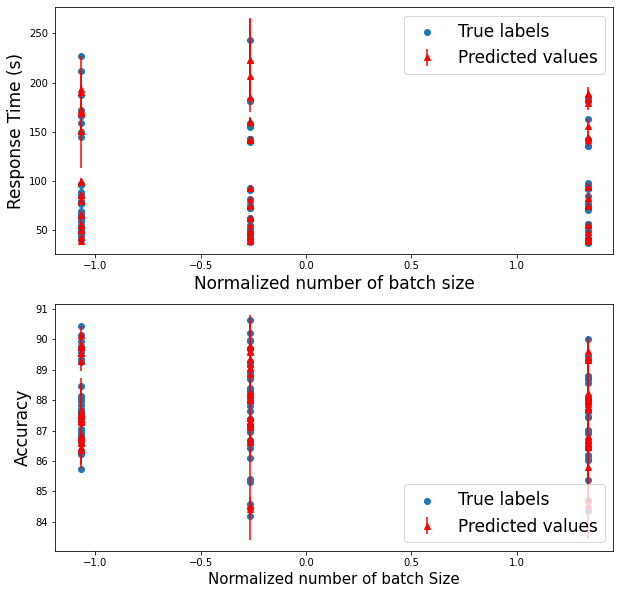

In [64]:
# Print the predictions and the true values
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

ax1.scatter(x_test[:,3], y_test_time, label='True labels')
ax1.errorbar(x_test[:,3], y_pred_time, yerr=y_test_time-y_pred_time, fmt='o', marker='^', c='r', label='Predicted values')

ax1.set_xlabel('Normalized number of batch size', fontsize=17)
ax1.set_ylabel('Response Time (s)', fontsize=17)

ax2.scatter(x_test[:,3], y_test_acc,label='True labels')
ax2.errorbar(x_test[:,3], y_pred_acc, yerr=y_test_acc-y_pred_acc, fmt='o', marker='^', c='r', label='Predicted values')

ax2.set_xlabel('Normalized number of batch Size', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=17)

ax1.legend(fontsize=17)
ax2.legend(fontsize=17)

dataParallelism 0.8223767715471778
executorCore 0.1357514464588322
learningRate 0.009393642155853138
batchSize 0.03247813983813675


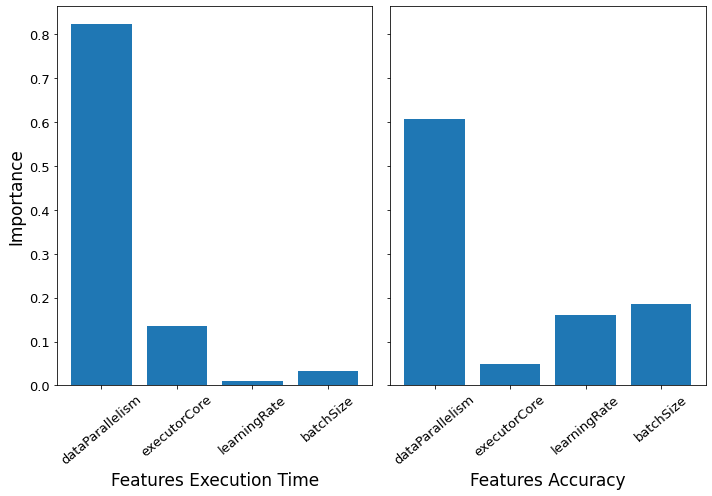

In [65]:
# Plot the features' importance

for f, imp in zip(['dataParallelism','executorCore','learningRate','batchSize'],r_t.feature_importances_ ):
    print(f, imp)
    
f, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,7))
ax1.bar(['dataParallelism','executorCore','learningRate','batchSize'], r_t.feature_importances_)
ax2.bar(['dataParallelism','executorCore','learningRate','batchSize'], r_acc.feature_importances_)
ax1.tick_params(axis='x',rotation=40)
ax1.tick_params(axis='both',labelsize=13)

ax2.tick_params(axis='x',rotation=40)
ax2.tick_params(axis='both',labelsize=13)


ax1.set_ylabel('Importance', fontsize=17)
ax1.set_xlabel('Features Execution Time', fontsize=17)
ax2.set_xlabel('Features Accuracy', fontsize=17)

plt.tight_layout()

*Regressions on experimental batch size modeling experiments* 

Defining the datasets

In [88]:
df_batch = pd.read_csv('experimentsBatchSize.csv', sep=";")
train_df = df_batch[['batchSize']]

labels_time = df_batch['running_time']
labels_acc = df_batch['accuracy']

train_df = scaler.fit_transform(train_df)

# Fit just the Random Forest regressor with a GridSearch crossval to find the best hyperparams
x_train, x_test, y_train_acc, y_test_acc = train_test_split(train_df, labels_acc, test_size=0.33, random_state = 42)
x_train, x_test, y_train_time, y_test_time = train_test_split(train_df, labels_time, test_size=0.33, random_state = 42)

Linear Regression

In [89]:
# LR for predicting time
lr_time = linear_model.LinearRegression().fit(x_train, y_train_time)

y_lr_time = lr_time.predict(x_test)

mse = mean_squared_error(y_test_time, y_lr_time)
r2 = r2_score(y_test_time, y_lr_time)
print(f'Time: MSE = {mse}, R2: {r2}')

Time: MSE = 12.00356120938224, R2: 0.00828146781654271


In [90]:
# LR for predicting accuracy
lr_time = linear_model.LinearRegression().fit(x_train, y_train_acc)

y_lr_time = lr_time.predict(x_test)

mse = mean_squared_error(y_test_acc, y_lr_time)
r2 = r2_score(y_test_acc, y_lr_time)
print(f'Time: MSE = {mse}, R2: {r2}')

Time: MSE = 0.7964219893594925, R2: 0.49702361880102064


Random Forest


In [72]:
reg_acc_batch = ensemble.RandomForestRegressor(random_state=42)
reg_time_batch = ensemble.RandomForestRegressor(random_state=42)

# First cross validation
print('Fitting the time')
cv_time_batch = GridSearchCV(estimator=reg_time_batch, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_time_batch.fit(x_train, y_train_time)

# Second cross val
print('Fitting the accuracy')
cv_acc_batch = GridSearchCV(estimator=reg_acc_batch, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_acc_batch.fit(x_train, y_train_acc)

Fitting the time
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   40.6s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  2.4min finished


Fitting the accuracy
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   40.5s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [ ]:
## Fit on the time
r_t_batch = cv_time_batch.best_estimator_.fit(x_train, y_train_time)

# test the performance on the train and the test set
y_pred = r_t_batch.predict(x_test)

# #higher resolution graph
X_grid = np.arange(min(x_train['batchSize']),max((x_train['batchSize'])),0.01)
X_grid = X_grid.reshape(len(X_grid),1) 
 
plt.scatter(x_test,y_test_time, color='red') #plotting real points
 
plt.title("Truth or Bluff(Random Forest - Smooth)")
plt.xlabel('Running Time')
plt.ylabel('Batch Size')
plt.show()

err = mean_squared_error(y_pred, y_test_time)

print('Mean Squared Error with the test set is for running time', err)

y_pred.shape